## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/villar/'
counts_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/villar/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/villar/'
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
mutation = 'Trspfl'
samp_num = '2'

# figure out if the notebook has already been done for this dataset and only run the
# visualizations. 
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

In [4]:
pre_load = False

## Loading up the data.

In [5]:
# Load in the count positions data.
data_mutant, names_mutant = kat.load_count_positions(mutation+"_"+samp_num+"_counts.csv",counts_path)
data_control, names_control = kat.load_count_positions("control_"+ samp_num +"_counts.csv",counts_path)

## Calculate Smoothed Vector Arrays

In [6]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
mutant_list = []
control_list = []
gene_list = []
for tr_m, tr_c, gene_name in zip(data_mutant, data_control, names_mutant):
    if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
        mutant_list.append(tr_m)
        control_list.append(tr_c)
        gene_list.append(gene_name)

In [7]:
max_pool = 20

# get smoothed vector arrays for all of the control data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_control = list(
            tqdm(
                p.imap(kat.get_smoothed_vector,
                       control_list),
                total=len(control_list)
            )
        )    

100%|██████████████████████████████████████| 6783/6783 [00:16<00:00, 413.08it/s]


In [8]:
# get smoothed vector arrays for all of the mutant data.
if pre_load == False:
    with Pool(max_pool) as p:
        pool_mutant = list(
            tqdm(
                p.imap(kat.get_smoothed_vector,
                       mutant_list),
                total=len(mutant_list)
            )
        )    

100%|██████████████████████████████████████| 6783/6783 [00:16<00:00, 417.56it/s]


## Determine KS statistic for all transcripts

In [9]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    len_list = []
    for tr_m, tr_c, index in zip(mutant_list, control_list, list(range(len(mutant_list)))):
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = pool_mutant[index]
        smoothed_vec_c, cumul_c = pool_control[index]
        ks = max(abs(cumul_m - cumul_c))
        ks_list.append(ks)
        len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, ks_list, len_list)))
    df_b.columns = ["gene_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [10]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df_b = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

(0.0, 0.7)

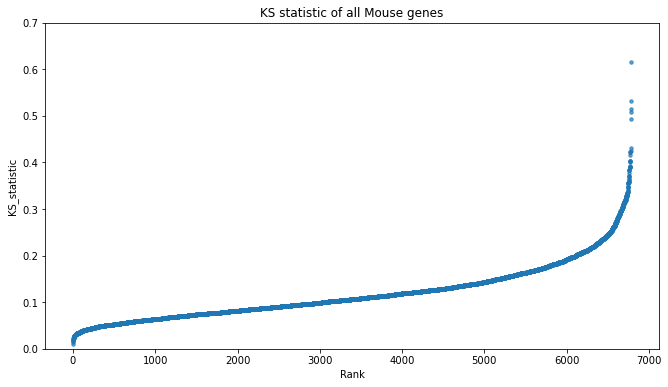

In [11]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Mouse genes")
plt.ylim(0,0.7)

In [12]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 220:
        size_groups.append(1)
    elif i >= 220 and i < 600:
        size_groups.append(2)
    elif i >= 600:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [13]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.35) & (df_b['size_groups'] == 2)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [14]:
len(diff_dist)

8

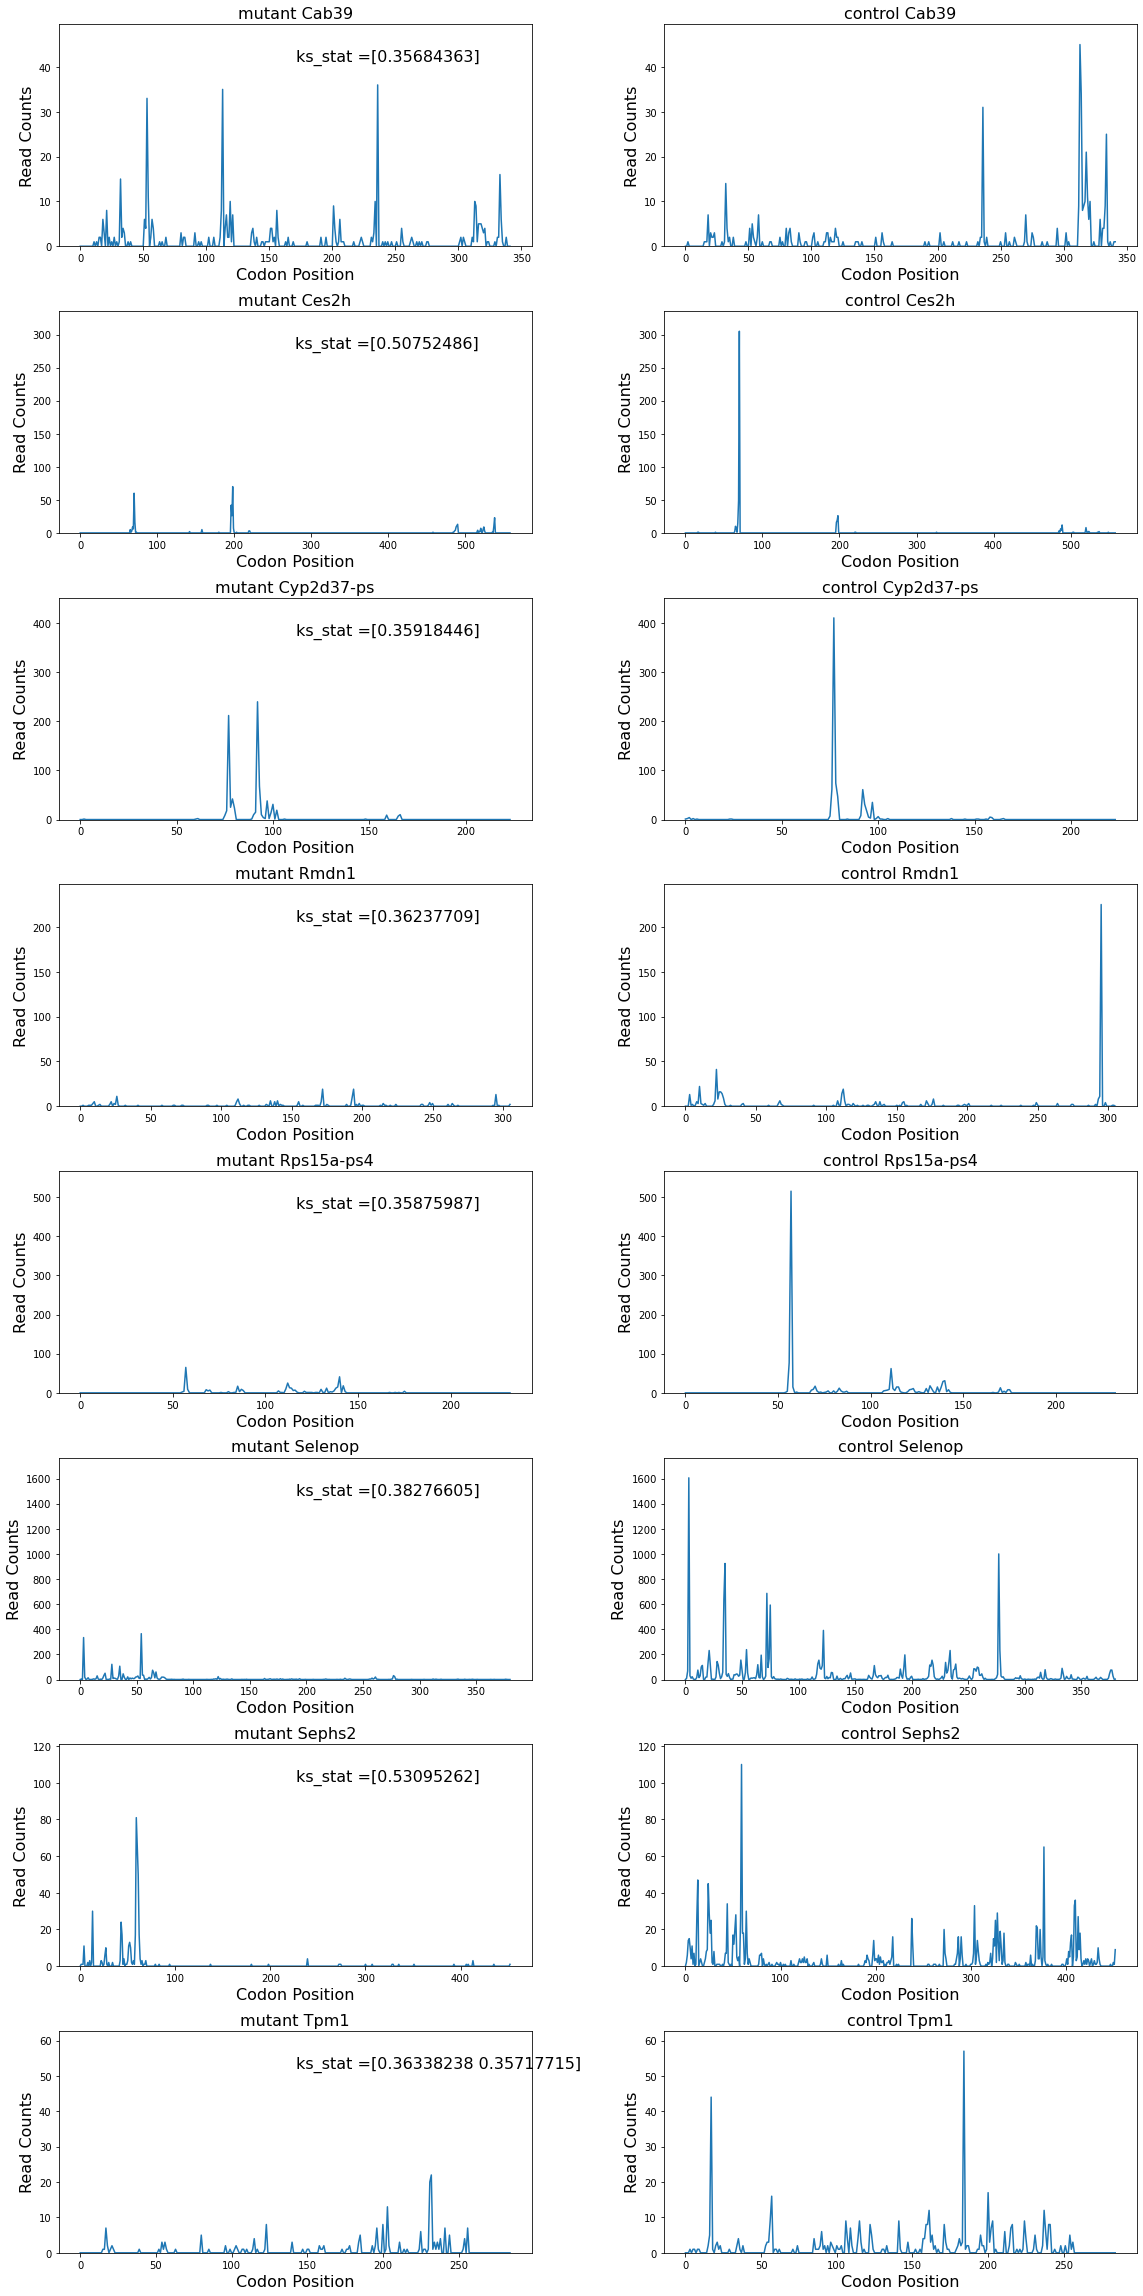

In [15]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = kat.big_dif(diff_dist, gene_list, mutant_list, control_list, figsize = (16,len(diff_dist)*4), fontsize = 16)

## Choose a gene of interest and observe the smooth and unsmooth array.

In [82]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'Gpx1'
my_vec_mutant = None
my_vec_control = None
for tr_m, tr_c, name in zip(data_mutant, data_control, names_mutant):
    if name == my_gene:
        my_vec_mutant = tr_m
        my_vec_control = tr_c
if my_vec_mutant.any() == None:
    print("No gene found")

In [83]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_vec_control+0.00000000001)

In [84]:
sum(my_vec_mutant)

1612

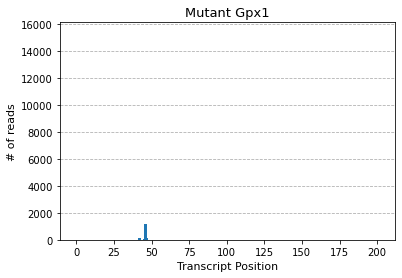

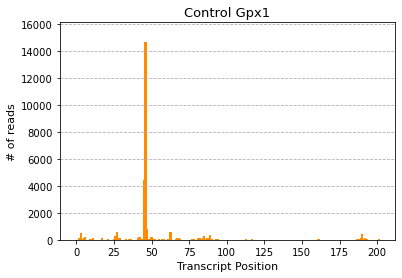

In [85]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant, width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Mutant " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_mutant_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_mutant))), my_vec_control, color = "darkorange", width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Control " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_control_array.pdf')

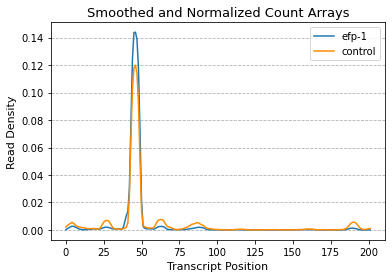

In [86]:
plt.plot(smoothed_vec_m, label = "efp-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "control", color = "darkorange")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene +'_smoothed.pdf')

In [74]:
ks = max(abs(cumul_m - cumul_c))

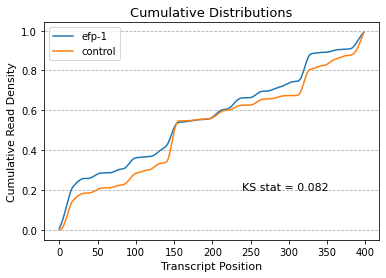

In [75]:
plt.plot(cumul_m, label = "efp-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(cumul_c, label = "control")
plt.text(len(cumul_m)*0.6, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_cumulative.pdf')